In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/archive.zip'
destination_path = '/content/data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(destination_path)

In [ ]:
!pip install opencv-python --upgrade

Found 4117 files belonging to 1 classes.


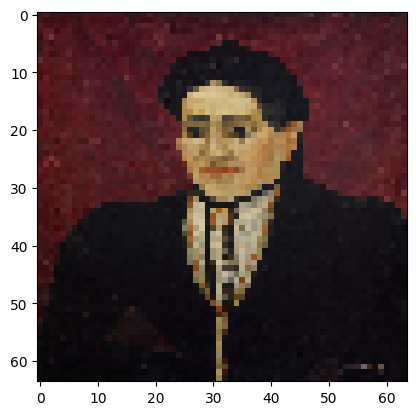

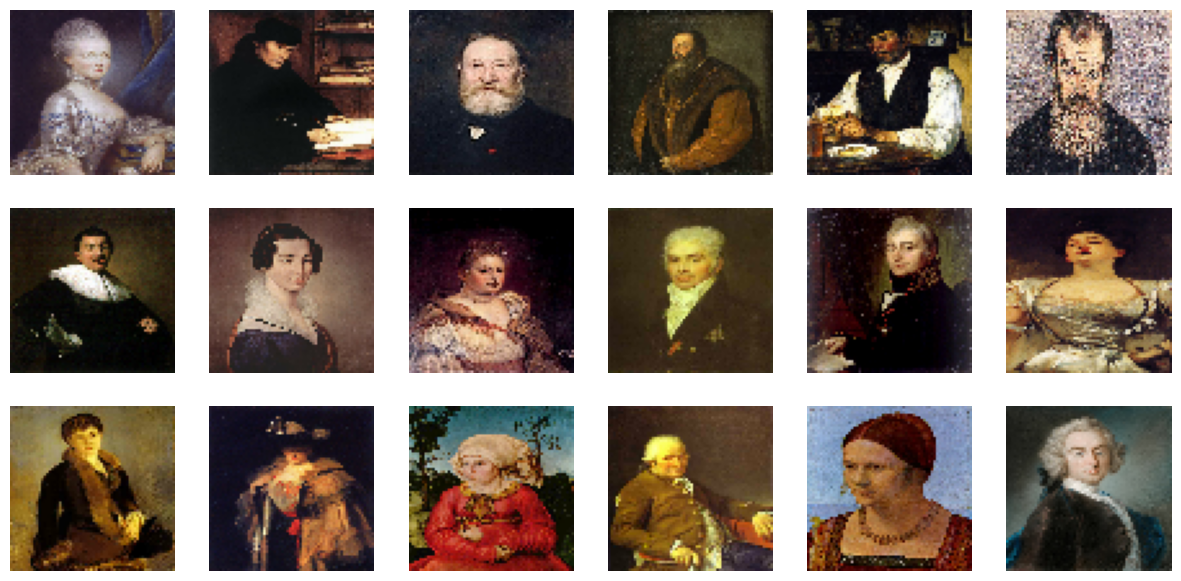

In [ ]:
# Importing Libraries
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
import random, math, numpy as np, matplotlib.pyplot as plt, seaborn as sns, PIL, tensorflow as tf, tqdm, warnings, zipfile
warnings.filterwarnings("ignore")


batch_s, data_fp = 64, "/content/data/Portraits/Portraits"

# Create a set of images of size of (64, 64) pixels
keras_data = tf.keras.preprocessing.image_dataset_from_directory(data_fp, label_mode = None,
                                                                 image_size = (64, 64), batch_size = batch_s)
for data_image in keras_data.take(1):
    plt.imshow(data_image[0].numpy().astype("uint8"))
    plt.show()

def Show_Img(data):
    plt.figure(figsize=(15,15))
    #data.take(1) returns  a batch of 64 images
    for data_image in keras_data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(data_image[i].numpy().astype("uint8"))
            ax.axis("off")

# plot the remaining images in dataset
Show_Img(keras_data)
# normalize pixel vals from images in the dataset in range 0 to 1
keras_data = keras_data.map(lambda x: x / 255.0)

In [ ]:
latent_dimension, g_resolution = 100, 2
seq_generator = Sequential()
seq_generator.add(Dense(4*4*256, activation="relu", input_dim=latent_dimension))
seq_generator.add(Reshape((4, 4, 256)))
seq_generator.add(UpSampling2D())
seq_generator.add(Conv2D(256, kernel_size=3, padding="same"))
seq_generator.add(BatchNormalization(momentum=0.8))
seq_generator.add(Activation("relu"))
seq_generator.add(UpSampling2D())
seq_generator.add(Conv2D(256, kernel_size=3, padding="same"))
seq_generator.add(BatchNormalization(momentum=0.8))
seq_generator.add(Activation("relu"))
seq_generator.add(UpSampling2D())
seq_generator.add(Conv2D(256, kernel_size=3, padding="same"))
seq_generator.add(BatchNormalization(momentum=0.8))
seq_generator.add(Activation("relu"))
seq_generator.add(UpSampling2D())
seq_generator.add(Conv2D(128, kernel_size=3, padding="same"))
seq_generator.add(BatchNormalization(momentum=0.8))
seq_generator.add(Activation("relu"))
seq_generator.add(Conv2D(3, kernel_size=3, padding="same"))
seq_generator.add(Activation("tanh"))


(-0.5, 63.5, 63.5, -0.5)

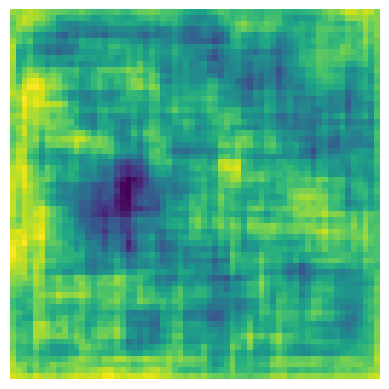

In [ ]:
# random seed and output from generator
seed = tf.random.normal([1, latent_dimension])
# 1 for generating a single row. mean:0, std:1
Generated_Portrait = seq_generator(seed, training=False)
# plot the image output of generator without training
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

In [ ]:
latent_dimension, g_resolution = 100, 2
seq_generator, discriminator = Sequential(), Sequential()

seq_generator.add(Dense(4*4*256, activation="relu", input_dim=latent_dimension))
seq_generator.add(Reshape((4, 4, 256)))
seq_generator.add(UpSampling2D())
seq_generator.add(Conv2D(256, kernel_size=3, padding="same"))
seq_generator.add(BatchNormalization(momentum=0.8))
seq_generator.add(Activation("relu"))
seq_generator.add(UpSampling2D())#
seq_generator.add(Conv2D(256, kernel_size=3, padding="same"))
seq_generator.add(BatchNormalization(momentum=0.8))
seq_generator.add(Activation("relu"))
seq_generator.add(UpSampling2D())
seq_generator.add(Conv2D(256, kernel_size=3, padding="same"))
seq_generator.add(BatchNormalization(momentum=0.8))
seq_generator.add(Activation("relu"))
seq_generator.add(UpSampling2D())
seq_generator.add(Conv2D(128, kernel_size=3, padding="same"))
seq_generator.add(BatchNormalization(momentum=0.8))
seq_generator.add(Activation("relu"))
seq_generator.add(Conv2D(3, kernel_size=3, padding="same"))
seq_generator.add(Activation("tanh"))

discriminator = Sequential()

discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2)) # alpha is slope for negative values
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1), (0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

In [ ]:
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.50001377]], shape=(1, 1), dtype=float32)


In [ ]:
class gan_class(tf.keras.Model):
    def __init__(self1, discriminator1, seq_generator, lnt_dimension):
        super(gan_class, self1).__init__()
        self1.discriminator1 = discriminator1
        self1.seq_generator = seq_generator
        self1.lnt_dimension = lnt_dimension

    def compile_method(self1, disc_optimizer, gen_optimizer, lossfn):
        super(gan_class, self1).compile(optimizer=disc_optimizer)
        self1.gen_optimizer = gen_optimizer
        self1.disc_optimizer = disc_optimizer
        self1.loss_fn = lossfn
        self1.disc_loss_metric = tf.keras.metrics.Mean(name="disc_loss")  # Change to disc_loss_metric
        self1.gen_loss_metric = tf.keras.metrics.Mean(name="gen_loss")  # Change to gen_loss_metric

    @property
    def metrics(self1):
        return [self1.disc_loss_metric, self1.gen_loss_metric]

    def train_step(self1, real_images):
        batch_size1 = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size1, self1.lnt_dimension))
        gen_imgs = self1.seq_generator(seed)
        comb_imgs = tf.concat([gen_imgs, real_images], axis=0)
        labels1 = tf.concat([tf.ones((batch_size1, 1)), tf.zeros((batch_size1, 1))], axis=0)
        labels1 += 0.05 * tf.random.uniform(tf.shape(labels1))

        # Train the discriminator
        with tf.GradientTape() as taper:
            predict1 = self1.discriminator1(comb_imgs)
            disc_loss = self1.loss_fn(labels1, predict1)

        grads = taper.gradient(disc_loss, self1.discriminator1.trainable_weights)
        self1.disc_optimizer.apply_gradients(zip(grads, self1.discriminator1.trainable_weights))
        seed = tf.random.normal(shape=(batch_size1, self1.lnt_dimension))

        mislabels = tf.zeros((batch_size1, 1))

        with tf.GradientTape() as taper:
            predict1 = self1.discriminator1(self1.seq_generator(seed))
            gen_loss = self1.loss_fn(mislabels, predict1)
        grads = taper.gradient(gen_loss, self1.seq_generator.trainable_weights)
        self1.gen_optimizer.apply_gradients(zip(grads, self1.seq_generator.trainable_weights))

        self1.disc_loss_metric.update_state(disc_loss)
        self1.gen_loss_metric.update_state(gen_loss)
        return {"disc_loss": self1.disc_loss_metric.result(), "gen_loss": self1.gen_loss_metric.result()}

In [ ]:
epochs = 1
#The optimizers for Generator and Discriminator
discriminator_opt, generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5), tf.keras.optimizers.Adamax(1.5e-4,0.5)

loss_function = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = gan_class(discriminator1=discriminator, seq_generator=seq_generator, lnt_dimension=latent_dimension)

#Compiling GAN Model
model.compile_method(disc_optimizer=discriminator_opt, gen_optimizer=generator_opt, lossfn=loss_function)

#Fitting the GAN
history = model.fit(keras_data, epochs=epochs)

48/65 [=====================>........] - ETA: 8:44 - disc_loss: 0.6795 - gen_loss: 0.7149

In [ ]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dimension])
    generated_image = seq_generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("Potraits{:02d}.png".format(i))
    return

#Generating images
Images = Potrait_Generator()
#Loading generated images
Generated_path = "./"
Potraits_generated = tf.keras.preprocessing.image_dataset_from_directory(Generated_path, label_mode = None)
#Plotting generated images
Show_Img(Potraits_generated)

In [ ]:
# A function to generate and save rotated face images
def retated_images_generator(seq_generator, input_image_path, num_rotations, latent_dimension):
    # Load and preprocess the input image
    input_image = tf.keras.preprocessing.image.load_img(input_image_path, target_size=(64, 64))
    input_array = tf.keras.preprocessing.image.img_to_array(input_image)
    input_array = (input_array.astype(np.float32) - 127.5) / 127.5  # Normalize to the range [-1, 1]
    input_array = np.expand_dims(input_array, axis=0)

    # Generating different rotations of the input image
    Generated_Rotations = []
    for i in range(num_rotations):
        seed = tf.random.normal(shape=(1, latent_dimension), dtype=tf.float32)  # Random seed
        combined_input = seed
        generated_rotation = seq_generator(combined_input, training=False)
        generated_rotation *= 255
        generated_rotation = generated_rotation.numpy()

        img = tf.keras.preprocessing.image.array_to_img(generated_rotation[0])
        Generated_Rotations.append(img)
        img.save(f"Generated_Rotation_{i + 1}.png")

    # Display the original and generated rotated images
    plt.figure(figsize=(15, 3))
    plt.subplot(1, num_rotations + 1, 1)
    plt.imshow(input_image)
    plt.title('Original')
    plt.axis('off')

    for i in range(num_rotations):
        plt.subplot(1, num_rotations + 1, i + 2)
        plt.imshow(Generated_Rotations[i])
        plt.title(f'Generated Rotation {i + 1}')
        plt.axis('off')

    plt.show()

# Example usage
input_image_path = '/content/data/Portraits/Portraits/000c6828b825f032af6047b46eba2686c.jpg'  # Replace with the path to your input image
num_rotations = 5  # Adjust as needed
retated_images_generator(seq_generator, input_image_path, num_rotations, latent_dimension)
